CODE BLOCK: 1

In [1]:
import torch
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
import model as mymodels

CODE BLOCK: 2

In [2]:
# CUDA?
# cuda = torch.cuda.is_available()
# print("CUDA Available?", cuda)
print("Apple MPS Available?", torch.backends.mps.is_available())
mps_device = torch.device("mps:0")
torch.set_default_device(mps_device)


Apple MPS Available? True


CODE BLOCK: 3

In [3]:
# Train data transformations
train_transforms = transforms.Compose([
    transforms.RandomApply([transforms.CenterCrop(22), ], p=0.1),
    transforms.Resize((28, 28)),
    transforms.RandomRotation((-15., 15.), fill=0),
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,)),
    ])

# Test data transformations
test_transforms = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))
    ])

CODE BLOCK: 4

In [4]:
train_data = datasets.MNIST('../data', train=True, download=True, transform=train_transforms)
test_data = datasets.MNIST('../data', train=False, download=True, transform=test_transforms)

CODE BLOCK: 5

In [5]:
batch_size = 512

kwargs = {'batch_size': batch_size, 'shuffle': False, 'num_workers': 2, 'pin_memory': True}

test_loader = torch.utils.data.DataLoader(test_data, **kwargs, generator=torch.Generator(device="mps:0"))
train_loader = torch.utils.data.DataLoader(train_data, **kwargs, generator=torch.Generator(device="mps:0"))

CODE BLOCK: 6

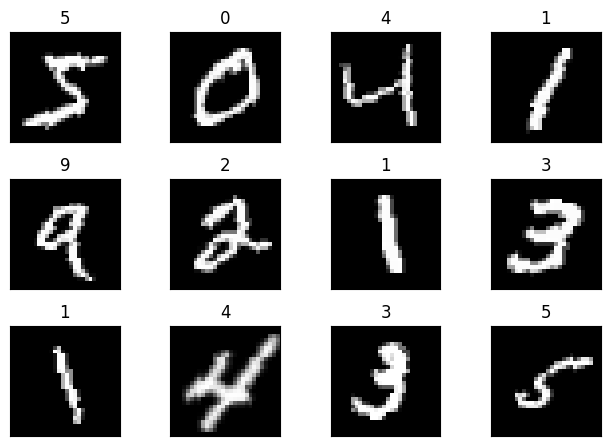

In [6]:
import matplotlib.pyplot as plt

batch_data, batch_label = next(iter(train_loader))

fig = plt.figure()

for i in range(12):
  plt.subplot(3,4,i+1)
  plt.tight_layout()
  plt.imshow(batch_data[i].squeeze(0), cmap='gray')
  plt.title(batch_label[i].item())
  plt.xticks([])
  plt.yticks([])

CODE BLOCK: 7

In [7]:
!pip install torchsummary
from torchsummary import summary
# use_cuda = torch.cuda.is_available()
# device = torch.device("cuda" if use_cuda else "cpu")
device = mps_device
model = mymodels.Net().to(device)
summary(model, input_size=(1, 28, 28))


[notice] A new release of pip is available: 23.3.2 -> 24.0
[notice] To update, run: pip install --upgrade pip
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 26, 26]             320
            Conv2d-2           [-1, 64, 24, 24]          18,496
            Conv2d-3          [-1, 128, 10, 10]          73,856
            Conv2d-4            [-1, 256, 8, 8]         295,168
            Linear-5                   [-1, 50]         204,850
            Linear-6                   [-1, 10]             510
Total params: 593,200
Trainable params: 593,200
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.67
Params size (MB): 2.26
Estimated Total Size (MB): 2.94
----------------------------------------------------------------


In [8]:
!pip install torchsummary
from torchsummary import summary
# use_cuda = torch.cuda.is_available()
# device = torch.device("cuda" if use_cuda else "cpu")
device = mps_device
model = mymodels.Net2().to(device)
summary(model, input_size=(1, 28, 28))


[notice] A new release of pip is available: 23.3.2 -> 24.0
[notice] To update, run: pip install --upgrade pip
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 26, 26]             288
            Conv2d-2           [-1, 64, 24, 24]          18,432
            Conv2d-3          [-1, 128, 10, 10]          73,728
            Conv2d-4            [-1, 256, 8, 8]         294,912
            Linear-5                   [-1, 50]         204,800
            Linear-6                   [-1, 10]             500
Total params: 592,660
Trainable params: 592,660
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.67
Params size (MB): 2.26
Estimated Total Size (MB): 2.93
----------------------------------------------------------------


CODE BLOCK: 8

In [9]:
# Data to plot accuracy and loss graphs
train_losses = []
test_losses = []
train_acc = []
test_acc = []

test_incorrect_pred = {'images': [], 'ground_truths': [], 'predicted_vals': []}

CODE BLOCK: 9

In [10]:

from tqdm import tqdm

def GetCorrectPredCount(pPrediction, pLabels):
  return pPrediction.argmax(dim=1).eq(pLabels).sum().item()

def train(model, device, train_loader, optimizer, criterion):
  model.train()
  pbar = tqdm(train_loader)

  train_loss = 0
  correct = 0
  processed = 0

  for batch_idx, (data, target) in enumerate(pbar):
    data, target = data.to(mps_device), target.to(mps_device)
    optimizer.zero_grad()

    # Predict
    pred = model(data)

    # Calculate loss
    loss = criterion(pred, target)
    train_loss+=loss.item()

    # Backpropagation
    loss.backward()
    optimizer.step()

    correct += GetCorrectPredCount(pred, target)
    processed += len(data)

    pbar.set_description(desc= f'Train: Loss={loss.item():0.4f} Batch_id={batch_idx} Accuracy={100*correct/processed:0.2f}')

  train_acc.append(100*correct/processed)
  train_losses.append(train_loss/len(train_loader))

def test(model, device, test_loader, criterion):
    model.eval()

    test_loss = 0
    correct = 0

    with torch.no_grad():
        for batch_idx, (data, target) in enumerate(test_loader):
            data, target = data.to(mps_device), target.to(mps_device)

            output = model(data)
            test_loss += criterion(output, target, reduction='sum').item()  # sum up batch loss

            correct += GetCorrectPredCount(output, target)


    test_loss /= len(test_loader.dataset)
    test_acc.append(100. * correct / len(test_loader.dataset))
    test_losses.append(test_loss)

    print('Test set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))


CODE BLOCK: 10

In [65]:
model = Net().to(device)
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=15, gamma=0.1, verbose=True)
# New Line
criterion = F.nll_loss
num_epochs = 20

for epoch in range(1, num_epochs+1):
  print(f'Epoch {epoch}')
  train(model, device, train_loader, optimizer, criterion)
  test(model, device, test_loader, criterion)
  scheduler.step()

Adjusting learning rate of group 0 to 1.0000e-02.
Epoch 1


Train: Loss=0.8394 Batch_id=117 Accuracy=38.40: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 118/118 [00:03<00:00, 30.55it/s]


Test set: Average loss: 0.4849, Accuracy: 8504/10000 (85.04%)

Adjusting learning rate of group 0 to 1.0000e-02.
Epoch 2


Train: Loss=0.3571 Batch_id=117 Accuracy=90.99: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 118/118 [00:03<00:00, 31.06it/s]


Test set: Average loss: 0.1109, Accuracy: 9650/10000 (96.50%)

Adjusting learning rate of group 0 to 1.0000e-02.
Epoch 3


Train: Loss=0.3220 Batch_id=117 Accuracy=95.47: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 118/118 [00:03<00:00, 31.38it/s]


Test set: Average loss: 0.0748, Accuracy: 9758/10000 (97.58%)

Adjusting learning rate of group 0 to 1.0000e-02.
Epoch 4


Train: Loss=0.2577 Batch_id=117 Accuracy=96.60: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 118/118 [00:03<00:00, 31.11it/s]


Test set: Average loss: 0.0614, Accuracy: 9811/10000 (98.11%)

Adjusting learning rate of group 0 to 1.0000e-02.
Epoch 5


Train: Loss=0.2377 Batch_id=117 Accuracy=97.12: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 118/118 [00:03<00:00, 30.97it/s]


Test set: Average loss: 0.0604, Accuracy: 9807/10000 (98.07%)

Adjusting learning rate of group 0 to 1.0000e-02.
Epoch 6


Train: Loss=0.3192 Batch_id=117 Accuracy=97.50: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 118/118 [00:03<00:00, 30.84it/s]


Test set: Average loss: 0.0451, Accuracy: 9839/10000 (98.39%)

Adjusting learning rate of group 0 to 1.0000e-02.
Epoch 7


Train: Loss=0.2118 Batch_id=117 Accuracy=97.74: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 118/118 [00:03<00:00, 30.93it/s]


Test set: Average loss: 0.0443, Accuracy: 9849/10000 (98.49%)

Adjusting learning rate of group 0 to 1.0000e-02.
Epoch 8


Train: Loss=0.2207 Batch_id=117 Accuracy=97.99: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 118/118 [00:03<00:00, 30.87it/s]


Test set: Average loss: 0.0415, Accuracy: 9864/10000 (98.64%)

Adjusting learning rate of group 0 to 1.0000e-02.
Epoch 9


Train: Loss=0.2223 Batch_id=117 Accuracy=98.12: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 118/118 [00:03<00:00, 30.77it/s]


Test set: Average loss: 0.0342, Accuracy: 9879/10000 (98.79%)

Adjusting learning rate of group 0 to 1.0000e-02.
Epoch 10


Train: Loss=0.1648 Batch_id=117 Accuracy=98.25: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 118/118 [00:03<00:00, 31.08it/s]


Test set: Average loss: 0.0320, Accuracy: 9885/10000 (98.85%)

Adjusting learning rate of group 0 to 1.0000e-02.
Epoch 11


Train: Loss=0.1401 Batch_id=117 Accuracy=98.30: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 118/118 [00:03<00:00, 31.07it/s]


Test set: Average loss: 0.0300, Accuracy: 9888/10000 (98.88%)

Adjusting learning rate of group 0 to 1.0000e-02.
Epoch 12


Train: Loss=0.1106 Batch_id=117 Accuracy=98.53: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 118/118 [00:03<00:00, 30.77it/s]


Test set: Average loss: 0.0295, Accuracy: 9891/10000 (98.91%)

Adjusting learning rate of group 0 to 1.0000e-02.
Epoch 13


Train: Loss=0.1434 Batch_id=117 Accuracy=98.55: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 118/118 [00:03<00:00, 31.10it/s]


Test set: Average loss: 0.0309, Accuracy: 9887/10000 (98.87%)

Adjusting learning rate of group 0 to 1.0000e-02.
Epoch 14


Train: Loss=0.1069 Batch_id=117 Accuracy=98.60: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 118/118 [00:03<00:00, 30.91it/s]


Test set: Average loss: 0.0288, Accuracy: 9900/10000 (99.00%)

Adjusting learning rate of group 0 to 1.0000e-02.
Epoch 15


Train: Loss=0.0926 Batch_id=117 Accuracy=98.73: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 118/118 [00:03<00:00, 30.76it/s]


Test set: Average loss: 0.0275, Accuracy: 9905/10000 (99.05%)

Adjusting learning rate of group 0 to 1.0000e-03.
Epoch 16


Train: Loss=0.0734 Batch_id=117 Accuracy=98.96: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 118/118 [00:03<00:00, 30.50it/s]


Test set: Average loss: 0.0211, Accuracy: 9929/10000 (99.29%)

Adjusting learning rate of group 0 to 1.0000e-03.
Epoch 17


Train: Loss=0.0698 Batch_id=117 Accuracy=99.06: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 118/118 [00:03<00:00, 30.85it/s]


Test set: Average loss: 0.0208, Accuracy: 9929/10000 (99.29%)

Adjusting learning rate of group 0 to 1.0000e-03.
Epoch 18


Train: Loss=0.0779 Batch_id=117 Accuracy=99.00: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 118/118 [00:03<00:00, 31.03it/s]


Test set: Average loss: 0.0207, Accuracy: 9930/10000 (99.30%)

Adjusting learning rate of group 0 to 1.0000e-03.
Epoch 19


Train: Loss=0.0628 Batch_id=117 Accuracy=99.07: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 118/118 [00:03<00:00, 30.63it/s]


Test set: Average loss: 0.0207, Accuracy: 9929/10000 (99.29%)

Adjusting learning rate of group 0 to 1.0000e-03.
Epoch 20


Train: Loss=0.0450 Batch_id=117 Accuracy=99.06: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 118/118 [00:03<00:00, 31.14it/s]


Test set: Average loss: 0.0207, Accuracy: 9933/10000 (99.33%)

Adjusting learning rate of group 0 to 1.0000e-03.


CODE BLOCK: 11

Text(0.5, 1.0, 'Test Accuracy')

Traceback (most recent call last):
  File "/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/multiprocessing/queues.py", line 239, in _feed
    reader_close()
  File "/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/multiprocessing/connection.py", line 178, in close
    self._close()
  File "/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/multiprocessing/connection.py", line 377, in _close
    _close(self._handle)
OSError: [Errno 9] Bad file descriptor


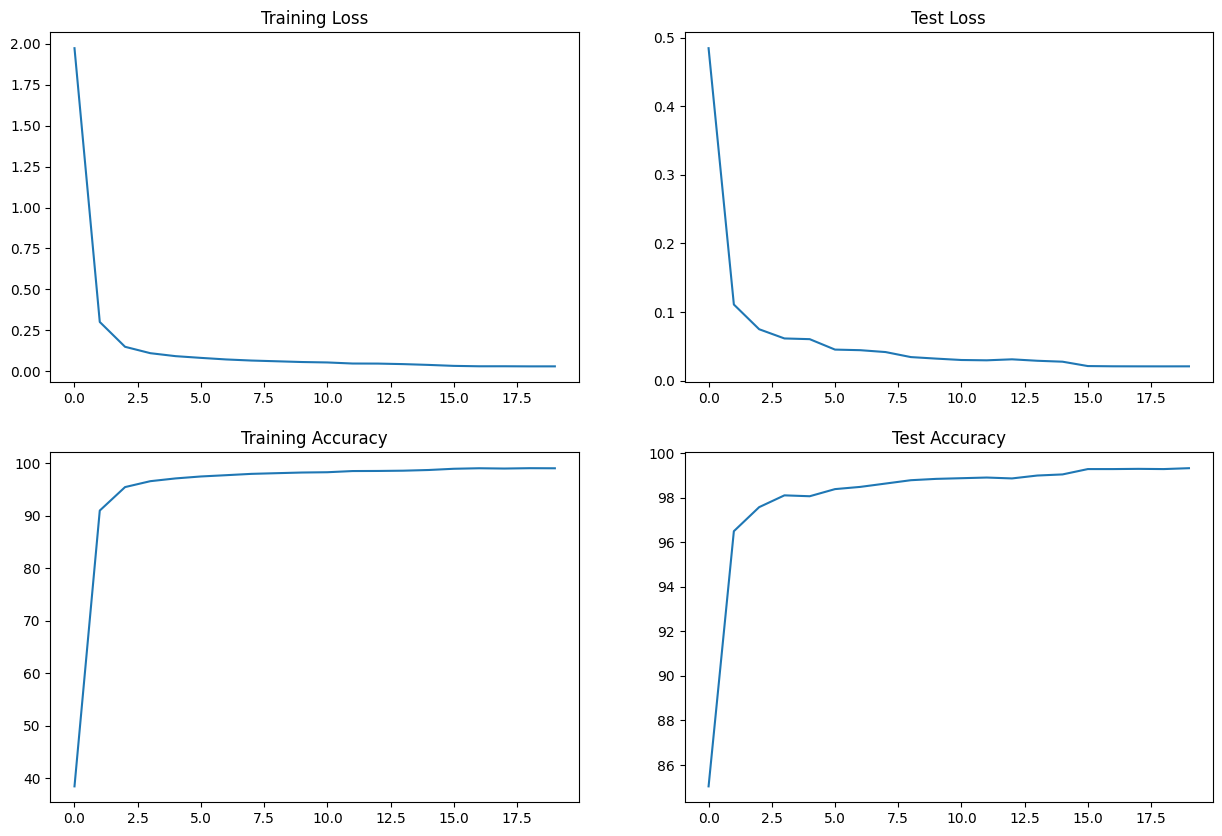

In [66]:
fig, axs = plt.subplots(2,2,figsize=(15,10))
axs[0, 0].plot(train_losses)
axs[0, 0].set_title("Training Loss")
axs[1, 0].plot(train_acc)
axs[1, 0].set_title("Training Accuracy")
axs[0, 1].plot(test_losses)
axs[0, 1].set_title("Test Loss")
axs[1, 1].plot(test_acc)
axs[1, 1].set_title("Test Accuracy")

In [67]:
!pip install torchsummary
from torchsummary import summary
# use_cuda = torch.cuda.is_available()
# device = torch.device("cuda" if use_cuda else "cpu")
device = mps_device
model = mymodels.Net().to(device)
summary(model, input_size=(1, 28, 28))


[notice] A new release of pip is available: 23.3.2 -> 24.0
[notice] To update, run: pip install --upgrade pip
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 26, 26]             320
            Conv2d-2           [-1, 64, 24, 24]          18,496
            Conv2d-3          [-1, 128, 10, 10]          73,856
            Conv2d-4            [-1, 256, 8, 8]         295,168
            Linear-5                   [-1, 50]         204,850
            Linear-6                   [-1, 10]             510
Total params: 593,200
Trainable params: 593,200
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.67
Params size (MB): 2.26
Estimated Total Size (MB): 2.94
----------------------------------------------------------------
